<h1 style="color:green" align="center"> Classification Model Pipeline</h1>

<h3 style="color:blue">Introduction</h3>
<h5>This project analyzes an HR dataset to understand factors influencing employee retention. The dataset consists of 15,000 rows and 10 features, including employee satisfaction, last evaluations, average monthly hours, and salary levels.</h5>
<h4 style="color:blue">Objective </h4>
<h5>To identify key patterns and build predictive models to understand and mitigate employee attrition.</h5>

<h2 style="color:blue">1. Importing the Necessary Libraries</h2>
<h5>I have prepared some custom functions in ../src/utils.py<br>
    Model and Hypaparamter search space is stored in ../src/utils/search_space_config.py
</h5>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
import shap
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
# import custom functions from src/utils.py
import sys
sys.path.append('../')
from src.utils import remove_correlated_features
from src.utils import plot_correlation_heatmap
from src.utils import remove_low_variance_features
from src.utils import plot_pca
from src.utils import plot_feature_importances
from src.utils import confusion_matrix_heatmap
from src.search_space_config import create_search_space

<h2 style="color:blue">2. Data Cleaning and Preparation</h2>

In this section, I will try to clean up and prepare the dataset for downstream preprocessing. This section will include:
<ul>
    <li>Loading the data from the data folder</li>
    <li>Checking for missing values or empty cells</li>
    <li>Performing imputation on missing values (or empty cells) if present</li>
    <li>Handling of categorical variables with one-hot encoding or label-encoding, if present</li>
    <li>Removing highly correlated variables (features) </li>
</ul>

In [2]:
data = pd.read_csv('../data/HR_comma_sep.csv')
data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [3]:
# Check for missing values or empty cells
data.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

In [4]:
# Identify the unique categories in the salary column
data['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [5]:
# Use one-hot encoding to convert department column to numerical values
department_dummies = pd.get_dummies(data['Department'],dtype=int)
department_dummies.head()

,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0


In [6]:
data = pd.concat([data, department_dummies], axis=1)
data.drop('Department', axis=1, inplace=True)
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,medium,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,low,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0


In [7]:
# Use label encoding to convert salary column to numerical values
data['salary'] = data['salary'].map({'low': 0, 'medium': 1, 'high': 2})
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [8]:
features_df = data.drop('left', axis=1)
target_df = data['left']

In [9]:
features_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0


<ul>
    <li>No missing values in the dataset.</li>
    <li>Department and salary require categories have been encoded.</li>
</ul>

In [10]:
# Get the correlation matrix of the features
corr_matrix = features_df.corr().abs()
corr_matrix

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
satisfaction_level,1.000000,0.105021,0.142970,0.020048,0.100866,0.058697,0.025605,0.050022,0.006373,0.006615,0.028649,0.012841,0.007172,0.005715,0.006919,0.004007,0.009185,0.009345
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,0.007104,0.008684,0.013002,0.001269,0.005471,0.002193,0.009645,0.009662,0.000311,0.001989,0.023031,0.017104,0.013742
number_project,0.142970,0.349333,1.000000,0.417211,0.196786,0.004741,0.006064,0.001803,0.003287,0.009703,0.004189,0.027356,0.009728,0.023064,0.000829,0.013388,0.000303,0.028596
average_montly_hours,0.020048,0.339742,0.417211,1.000000,0.127755,0.010143,0.003544,0.002242,0.006967,0.001177,0.000524,0.010783,0.000834,0.008210,0.005494,0.001718,0.002444,0.013638
time_spend_company,0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.067433,0.048715,0.006053,0.021116,0.003909,0.022194,0.115436,0.012096,0.003919,0.015150,0.030111,0.027991
Work_accident,0.058697,0.007104,0.004741,0.010143,0.002120,1.000000,0.039245,0.009247,0.009293,0.017167,0.012836,0.015649,0.011242,0.011367,0.001246,0.004955,0.012079,0.006070
promotion_last_5years,0.025605,0.008684,0.006064,0.003544,0.067433,0.039245,1.000000,0.098119,0.038942,0.021268,0.004852,0.001531,0.128087,0.049253,0.037288,0.012353,0.035605,0.035799
salary,0.050022,0.013002,0.001803,0.002242,0.048715,0.009247,0.098119,1.000000,0.010959,0.002800,0.012759,0.004599,0.156665,0.011599,0.007669,0.035599,0.029888,0.018630
IT,0.006373,0.001269,0.003287,0.006967,0.006053,0.009293,0.038942,0.010959,1.000000,0.070240,0.069293,0.067949,0.062500,0.073524,0.075503,0.184302,0.124705,0.140484
RandD,0.006615,0.005471,0.009703,0.001177,0.021116,0.017167,0.021268,0.002800,0.070240,1.000000,0.054629,0.053570,0.049274,0.057965,0.059525,0.145300,0.098315,0.110755


**Checking for correlation within the features** 

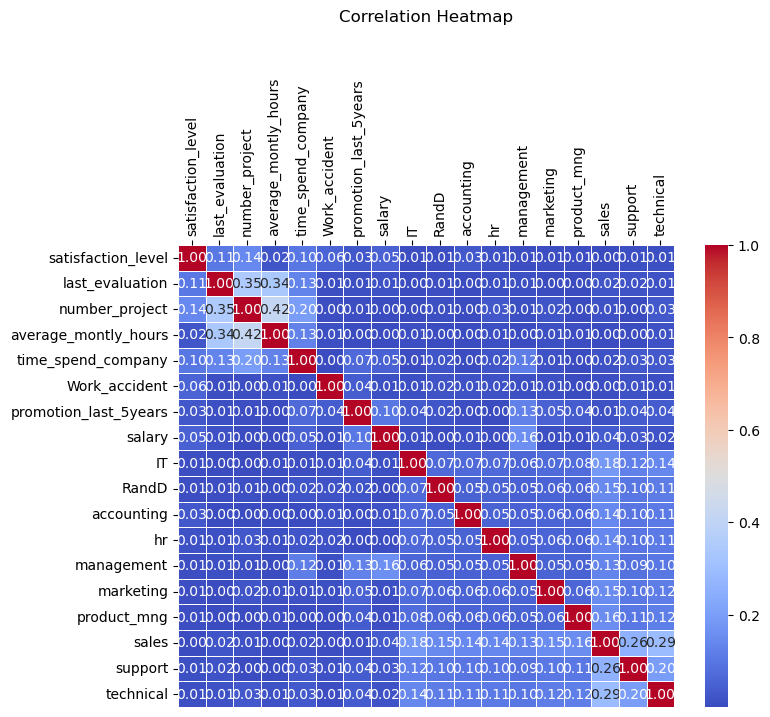

In [11]:
plot_correlation_heatmap(features_df)

From the correlation matrix heatmap, we can draw the following conclusions:
<ul>
    <li>Correlation between features: There is little or no correlation between the features and as such,
    they can be considered independent features. </li>
    <li>Most correlated features: The features which have the highest correlation between them (0.42) are "number_project"
    and "average_monthly_hours"</li>
</ul>

In [12]:
features_df = remove_correlated_features(features_df, 0.9)
features_df.head()
print(features_df.shape)

(14999, 18)


<h2 style="color:blue">3. Exploratory Data Analysis (EDA)</h2>

In this section, I will try to explore the data more, to understand some feature-target relationships. This section will include:
<ul>
    <li>Check for class balcance</li>
    <li>Perform PCA to identify and visualize clusters (to know if I would be able to find a good model)</li>
    <li>Remove low variance features (if any)</li>
</ul>

In [13]:
# Check for balance in the target variable
target_df.value_counts()

left
0    11428
1     3571
Name: count, dtype: int64

In [14]:
# Statistics of the features
features_df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268,0.594706,0.081805,0.052470,0.051137,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281,0.637183,0.274077,0.222981,0.220284,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Features are of different scales, therefore scaling would be needed during date preprocessing section** 

In [15]:
# Scaled statistics of the features to see the variability of the features
pd.DataFrame(MinMaxScaler().fit_transform(features_df), columns=features_df.columns).describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,0.360611,0.490889,0.187279,0.144610,0.021268,0.297353,0.081805,0.052470,0.051137,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345
std,0.273220,0.267452,0.246518,0.233379,0.182517,0.351719,0.144281,0.318591,0.274077,0.222981,0.220284,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.384615,0.312500,0.200000,0.280374,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.604396,0.562500,0.400000,0.485981,0.125000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.802198,0.796875,0.600000,0.696262,0.250000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**The standard deviation varies slightly across features, I might consider removing low variance features (if any)** 

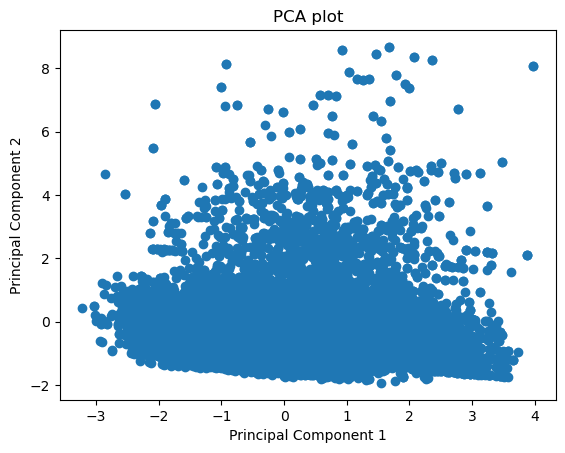

In [16]:
plot_pca(features_df)

**Checking for low variance features, which would probably have less impact on the target** 

In [17]:
features_df = remove_low_variance_features(features_df, 0.01)
print(features_df.shape)
features_df.head()

(14999, 18)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0


In [18]:
print(features_df.shape)
features_df.head()

(14999, 18)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0


From the EDA analysis, we can draw the following conclusions:
<ul>
    <li>Class Imbalance: There seems to be an imbalance in the class labels (76% for class 0, 24% for class 1)
    and this might affect the model's performance (the model might find it difficult in predicting outcomes effectively)</li>
    <li>Overlapping clusters: The PCA plot shows no distinct (clear) boundaries and this indicates that the features may not
    provide enough information to seperate classes or predict the outcomes effectively</li>
    <li>Low Variance : No feature had variance below the threshold and as such, no feature was removed</li>
</ul>

<h2 style="color:blue"> 4. Data Preprocessing</h2>

In this section, I will preprocess the data for training. This section will include:
<ul>
    <li>Scaliing</li>
    <li>Transformation (if required)</li>
    <li>Test-Train Split</li>
</ul>

In [19]:
# Scale the features using MaxMinScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features_df = scaler.fit_transform(features_df)

In [20]:
X = scaled_features_df
y = target_df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h2 style="color:blue"> 5. Model Selection, Feature Engineering and Hyperparameter Optimization</h2>

In this section, I seek to select the best model, features (and/or feature combinations) and hyperparameters. This section will include:
<ul>
    <li>K-fold Cross Validation</li>
    <li>Feature Engineering (Selecting the best combination of features using selectKBest)</li>
    <li>Hyperparameter Optimization (Bayesian Optimization using hyperopt) </li>
</ul>

In [21]:

# Use logistic regression to classify the data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.787


In [22]:
model.score(X_test, y_test)

0.787

In [23]:
n_features = X_train.shape[1]
n_features

18

In [ ]:
search_space = create_search_space(n_features)

In [25]:

# Objective function to minimize
def objective(params):
    model_name = params['model']['type']
    del params['model']['type']
    
    if model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(**params['model'])
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(**params['model'])
    elif model_name == 'XGBClassifier':
        model = XGBClassifier(**params['model'])
    elif model_name == 'LGBMClassifier':
        model = LGBMClassifier(**params['model'],verbosity=-1)
    elif model_name == 'CatBoostClassifier':
        model = CatBoostClassifier(**params['model'], verbose=False)
    elif model_name == 'GaussianNB':
        model = GaussianNB()
    elif model_name == 'KNeighborsClassifier':
        model = KNeighborsClassifier(**params['model'])
    elif model_name == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(**params['model'])
    elif model_name == 'AdaBoostClassifier':
        model = AdaBoostClassifier(**params['model'])
    elif model_name == 'GradientBoostingClassifier':
        model = GradientBoostingClassifier(**params['model'])
    elif model_name == 'ExtraTreesClassifier':
        model = ExtraTreesClassifier(**params['model'])

    model_pipeline = make_pipeline(
        PolynomialFeatures(degree=params['polynomialfeatures_degree']),
        SelectKBest(f_regression, k=params['selectkbest_k']),
        model
    )
    
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_log_loss')
    log_loss_cv = -scores.mean() 
    
    return {
        'loss': log_loss_cv,
        'status': STATUS_OK,
        'model_pipeline': model_pipeline,
    }

trials = Trials()
best = fmin(objective, search_space, algo=tpe.suggest, max_evals=20, trials=trials)

100%|██████████| 20/20 [00:49<00:00,  2.47s/trial, best loss: 0.06657080172416682]


In [26]:
best_params = space_eval(search_space, best)
best_params

{'model': {'learning_rate': 0.28962605439575495,
  'max_depth': 9,
  'n_estimators': 290,
  'type': 'XGBClassifier'},
 'polynomialfeatures_degree': 2,
 'selectkbest_k': 16}

<h2 style="color:blue">Model Re-training, Inference, Evaluation and Saving</h2>

In this section, I will re-train with the best model and hyper-paramaters from the previous secction. This section will include:
<ul>
    <li>Model Re-training</li>
    <li>Feature Importance</li>
    <li>Model Saving</li>
</ul>

In [27]:
best_model_name = best_params['model']['type']
best_model_name

'XGBClassifier'

In [28]:
best_params['model']

{'learning_rate': 0.28962605439575495,
 'max_depth': 9,
 'n_estimators': 290,
 'type': 'XGBClassifier'}

In [29]:
# Rebuild the pipeline with the best parameters
best_model_name = best_params['model']['type']
del best_params['model']['type']

if best_model_name == 'RandomForestClassifier':
    best_model = RandomForestClassifier(**best_params['model'])
elif best_model_name == 'LogisticRegression':
    best_model = LogisticRegression(**best_params['model'])
elif best_model_name == 'XGBClassifier':
    best_model = XGBClassifier(**best_params['model'])
elif best_model_name == 'LGBMClassifier':
    best_model = LGBMClassifier(**best_params['model'],verbosity=-1, force_row_wise=True)
elif best_model_name == 'CatBoostClassifier':
    best_model = CatBoostClassifier(**best_params['model'], verbose=False)
elif best_model_name == 'GaussianNB':
    best_model = GaussianNB()
elif best_model_name == 'KNeighborsClassifier':
    best_model = KNeighborsClassifier(**best_params['model'])
elif best_model_name == 'DecisionTreeClassifier':
    best_model = DecisionTreeClassifier(**best_params['model'])
elif best_model_name == 'AdaBoostClassifier':
    best_model = AdaBoostClassifier(**best_params['model'])
elif best_model_name == 'GradientBoostingClassifier':
    best_model = GradientBoostingClassifier(**best_params['model'])
elif best_model_name == 'ExtraTreesClassifier':
    best_model = ExtraTreesClassifier(**best_params['model'])


# Create the pipeline with the best parameters
best_model_pipeline = make_pipeline(
    PolynomialFeatures(degree=best_params['polynomialfeatures_degree']),  # Use the best degree
    SelectKBest(f_regression, k=best_params['selectkbest_k']),  # Use the best k features
    best_model
)

In [30]:
# Fit the pipeline on the full training data
best_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('selectkbest',
                 SelectKBest(k=16,
                             score_func=<function f_regression at 0x000001D7CF68D940>)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=Fa...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.28962605439575495, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=290,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [31]:
best_model_pipeline.score(X_test, y_test)

0.9876666666666667

In [32]:
selected_features_indices = best_model_pipeline.named_steps['selectkbest'].get_support(indices=True)
poly = best_model_pipeline.named_steps['polynomialfeatures']
transformed_feature_names = poly.get_feature_names_out(input_features=features_df.columns)
# map the selected indices to the transformed feature names
selected_features = transformed_feature_names[selected_features_indices]
selected_features

array(['satisfaction_level', 'salary', 'satisfaction_level^2',
       'satisfaction_level last_evaluation',
       'satisfaction_level number_project',
       'satisfaction_level average_montly_hours',
       'satisfaction_level Work_accident', 'satisfaction_level salary',
       'last_evaluation number_project',
       'last_evaluation average_montly_hours',
       'last_evaluation time_spend_company', 'number_project^2',
       'number_project average_montly_hours',
       'number_project time_spend_company',
       'average_montly_hours time_spend_company', 'Work_accident^2'],
      dtype=object)

In [33]:
# Get the feature importances
if best_model_name == 'RandomForestClassifier':
    feature_importances = best_model_pipeline.named_steps['randomforestclassifier'].feature_importances_
elif best_model_name == 'XGBClassifier':
    feature_importances = best_model_pipeline.named_steps['xgbclassifier'].feature_importances_
elif best_model_name == 'LGBMClassifier':
    feature_importances = best_model_pipeline.named_steps['lgbmclassifier'].feature_importances_
elif best_model_name == 'CatBoostClassifier':
    feature_importances = best_model_pipeline.named_steps['catboostclassifier'].feature_importances_
elif best_model_name == 'DecisionTreeClassifier':
    feature_importances = best_model_pipeline.named_steps['decisiontreeclassifier'].feature_importances_
elif best_model_name == 'AdaBoostClassifier':
    feature_importances = best_model_pipeline.named_steps['adaboostclassifier'].feature_importances_
elif best_model_name == 'GradientBoostingClassifier':
    feature_importances = best_model_pipeline.named_steps['gradientboostingclassifier'].feature_importances_
elif best_model_name == 'ExtraTreesClassifier':
    feature_importances = best_model_pipeline.named_steps['extratreesclassifier'].feature_importances_

feature_importances
# map the feature importances to the selected features
selected_features_importances = pd.Series(feature_importances, index=selected_features)
# Sort the features by importance
selected_features_importances = selected_features_importances.sort_values(ascending=False)
selected_features_importances

satisfaction_level number_project          0.400539
last_evaluation time_spend_company         0.157446
satisfaction_level                         0.141732
number_project^2                           0.073110
satisfaction_level average_montly_hours    0.067991
average_montly_hours time_spend_company    0.030707
satisfaction_level Work_accident           0.022933
satisfaction_level last_evaluation         0.019329
last_evaluation number_project             0.017308
salary                                     0.014810
number_project average_montly_hours        0.014331
satisfaction_level salary                  0.014320
number_project time_spend_company          0.013820
last_evaluation average_montly_hours       0.011624
satisfaction_level^2                       0.000000
Work_accident^2                            0.000000
dtype: float32

**From the feature importance, we can see the features that are most important, in general** 

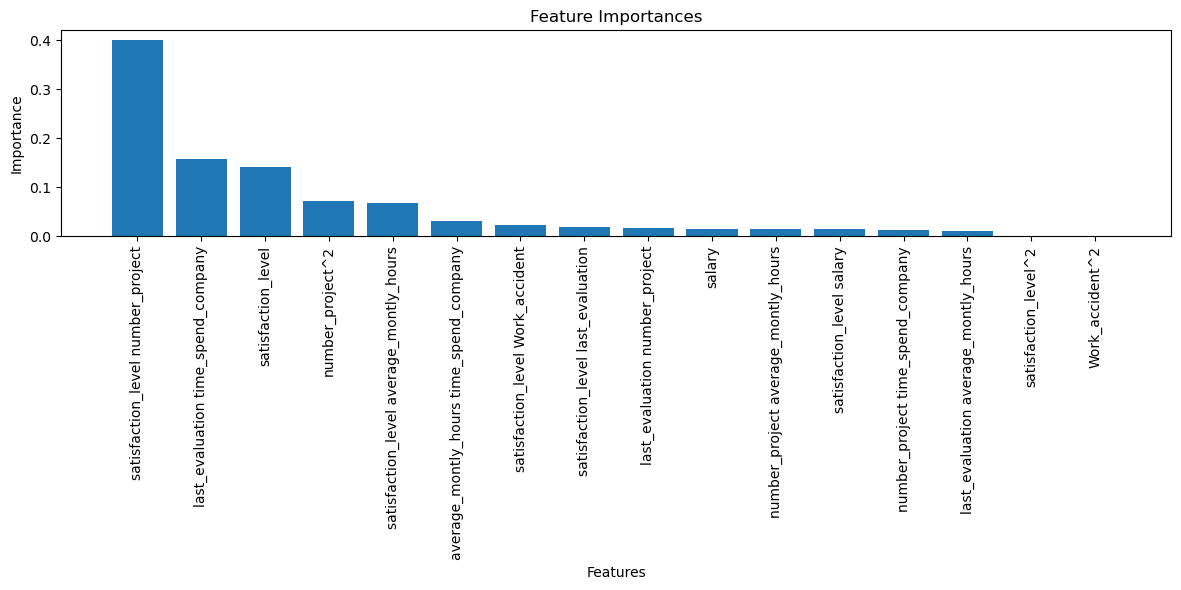

In [34]:
plot_feature_importances(feature_importances, selected_features)

<h2 style="color:blue" align="center">Model Performance Metrics</h2>

In this section, I seek to access and discuss the performance of the model. This section will include:
<ol>
    <li>Confussion Matrix</li>
    <li>Classification Report</li>
</ol>

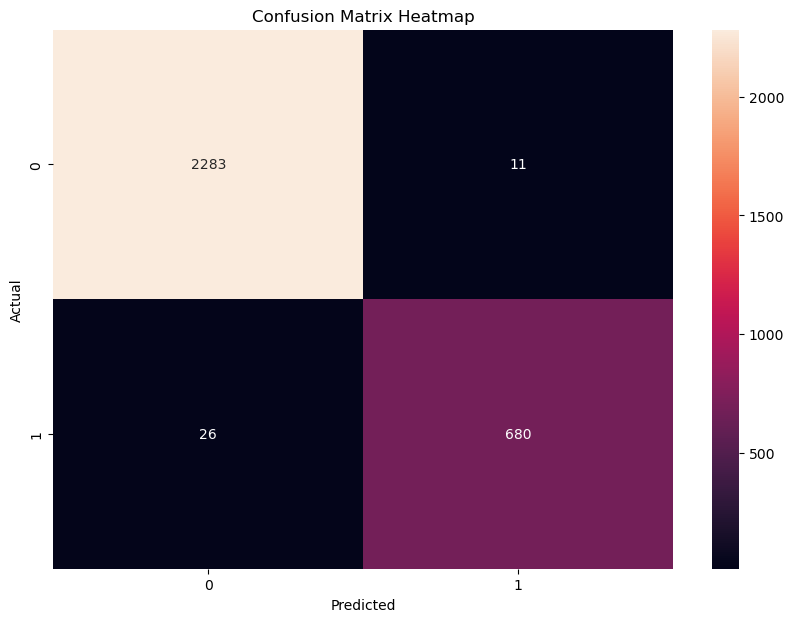

In [35]:
y_pred = best_model_pipeline.predict(X_test)
confusion_matrix_heatmap(y_test, y_pred)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2294
           1       0.98      0.96      0.97       706

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



In [44]:
preprocessor = best_model_pipeline[:-1] 
preprocessor

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('selectkbest',
                 SelectKBest(k=16,
                             score_func=<function f_regression at 0x000001D7CF68D940>))])

In [41]:
model = best_model_pipeline.named_steps[best_model_name.lower()]  # Extract the model
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.28962605439575495,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=290, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [45]:
X_test_preprocessed = preprocessor.transform(X_test)
X_test_preprocessed

array([[0.61538462, 0.5       , 0.37869822, ..., 0.        , 0.        ,
        1.        ],
       [0.86813187, 0.        , 0.75365294, ..., 0.        , 0.        ,
        0.        ],
       [0.65934066, 0.        , 0.43473011, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.75824176, 0.5       , 0.57493056, ..., 0.025     , 0.05665888,
        0.        ],
       [0.87912088, 0.5       , 0.77285352, ..., 0.        , 0.        ,
        0.        ],
       [0.24175824, 0.        , 0.05844705, ..., 0.375     , 0.06483645,
        0.        ]])

In [46]:
explainer = shap.Explainer(model)
explainer

In [47]:
shap_values = explainer(X_test_preprocessed)
shap_values

.values =
array([[-1.6171149 ,  0.01367485,  0.        , ..., -0.05195956,
        -1.3288879 ,  0.        ],
       [-1.0786111 , -0.00804793,  0.        , ...,  0.1988373 ,
        -1.5935664 ,  0.        ],
       [-1.9046643 ,  0.03541396,  0.        , ..., -0.0663872 ,
        -1.6267302 ,  0.        ],
       ...,
       [-0.21792345,  0.01130347,  0.        , ..., -0.04476238,
        -2.57522   ,  0.        ],
       [-2.0298605 ,  0.06567021,  0.        , ..., -0.00270851,
        -1.403024  ,  0.        ],
       [ 0.55647683,  0.17177683,  0.        , ..., -0.0178378 ,
         1.669354  ,  0.        ]], dtype=float32)

.base_values =
array([-1.7177169, -1.7177169, -1.7177169, ..., -1.7177169, -1.7177169,
       -1.7177169], dtype=float32)

.data =
array([[0.61538462, 0.5       , 0.37869822, ..., 0.        , 0.        ,
        1.        ],
       [0.86813187, 0.        , 0.75365294, ..., 0.        , 0.        ,
        0.        ],
       [0.65934066, 0.        , 0.43473011

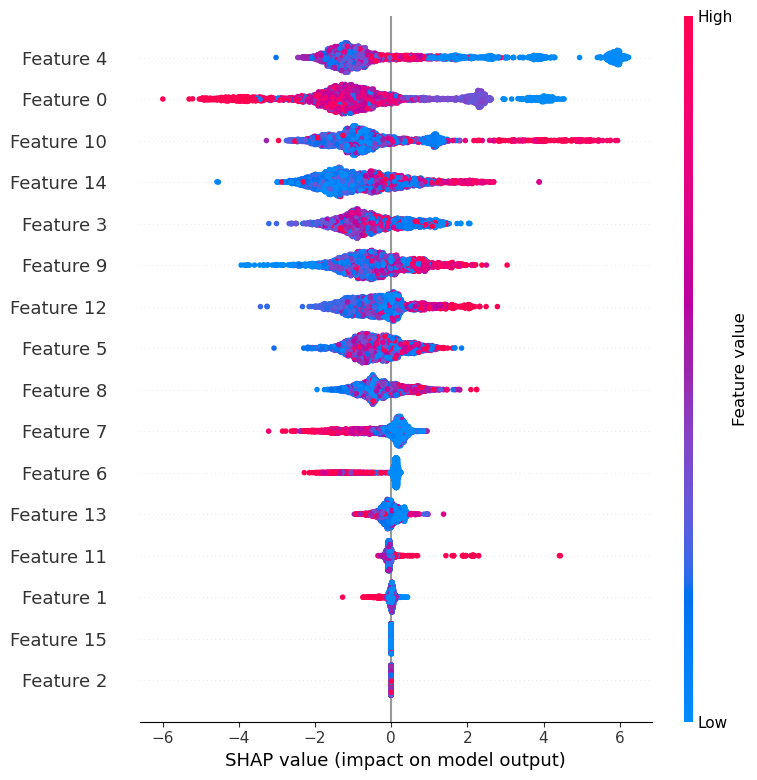

In [48]:
shap.summary_plot(shap_values, X_test_preprocessed)

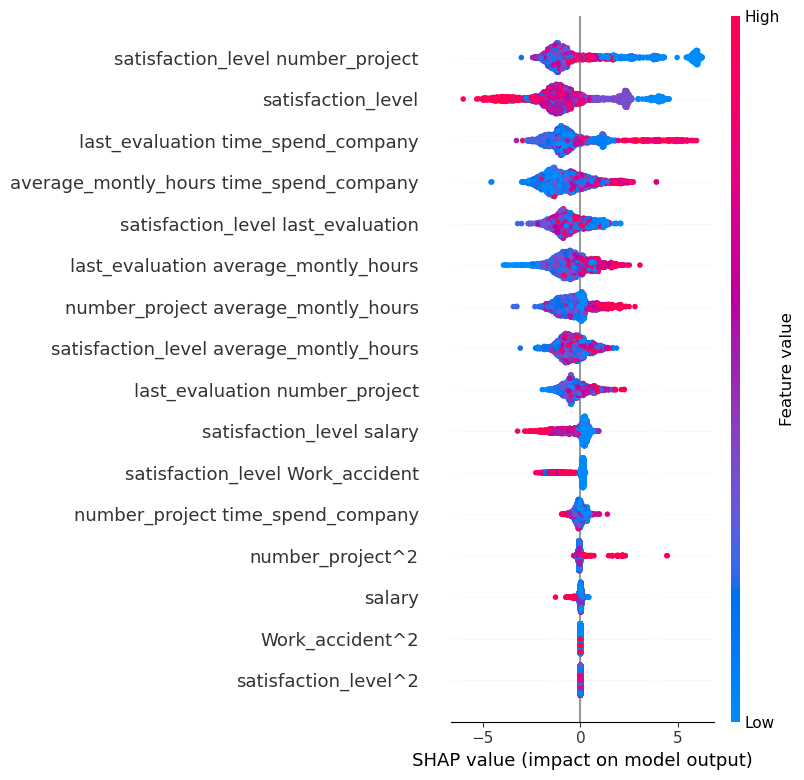

In [56]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=selected_features, show=False)
plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches="tight")

**From SHAP, we can identfy the features (or feature combinations) that impact on the model.** <br>
**Clearly low satisfaction_level*number_project have a positive impact on the model i.e lead to the positive class prediction (meaning the employee would leave).** 